In [24]:
from scipy.linalg import sqrtm
import cvxpy as cp
from sympy.utilities.lambdify import lambdify
import sympy as sp
import numpy as np
from scipy.linalg import solve_discrete_are as dare 
from scipy.signal import cont2discrete
import time
from matplotlib.pyplot import *


Coupled masses dynamical system:

$$
\begin{cases}
m_1\ddot{y}_1 + k(y_1 - y_2) = F \\ 
m_2\ddot{y}_2 + k(y_2 - y_1) = 0
\end{cases}
$$

In [25]:
# system parameters
m_1 = 1
m_2 = 3
K = 100

param = m_1, m_2, K
u_d = 2

x_d = np.array([0.7,0.5,0,0])
Q = 10*np.diag([1,100,1,1])

R = np.array([0.1])
C = np.array([[1, 0, 0 ,0]])
D = np.array([[0, 0]])
t0 = 0
T = 5
freq = 50
N = int(freq*T)
dt = 1/freq
t = np.array(range(N+1))*dt

In [26]:

A = np.array([[0,0,1,0],
             [0,0,0,1],
             [-K/m_1, K/m_1, 0, 0],
             [K/m_2, -K/m_2, 0, 0]])

B = np.array([[0],
             [0],
             [1/m_1],
             [0]])

In [27]:
A_d, B_d, C_d, D_d, _ = cont2discrete((A,B,C,D), dt)

def dlqr(A, B, Q, R):
    '''Discrete time LTI LQR'''
    # Solve the DARE
    P = dare(A, B, Q, R)
    # Compute the LQR gain
    R_inv = np.linalg.inv(R + B.T @ P @ B )
    K = R_inv @ (B.T @ P @ A)
    return K, P

K_LQR, P = dlqr(A_d, B_d, Q, R)

In [28]:
M_mat = np.array([[m_1, 0], [0, m_2]])

def V_fun(x, param):
    m1, m2, k = param
    y1, y2 = x
    V1 = k*(y1 - y2)
    V2 = k*(y2 - y1)
    out = cp.bmat((V1,
            V2))
    return out

In [29]:
# define dimensions
H, n, m = 20, 2, 1

# define variables
POS = cp.Variable((n, H+2), name='POS')
U = cp.Variable((m, H+1), name='U')


# define parameters
Psqrt = sqrtm(P)
Qsqrt = sqrtm(Q)
Rsqrt = sqrtm([R])
U_max = cp.Parameter(m, name='U_max')
U_min = cp.Parameter(m, name='U_min')

x_init_0 = cp.Parameter(n, name='x_init_0')
x_init_1 = cp.Parameter(n, name='x_init_1')

VEL = (POS[:,1:] - POS[:,:-1])/(dt) 
X = cp.vstack((POS[:,1:], VEL))

# define objective
objective = cp.Minimize(cp.sum_squares(Psqrt@X[:,H]) + cp.sum_squares(Qsqrt@X[:,:H])
                          + cp.sum_squares(Rsqrt@U)) 

ACC = (POS[:,2:] - 2*POS[:,1:-1] + POS[:,:-2])
DYN = M_mat @ ACC + (dt**2)*V_fun(POS[:,1:-1], param) - (dt**2)*(np.array([[1], [0]])@ U[:,:-1]) #(U[:,:-1] + U[:,1:])/2 )

# define constraints
constraints = [DYN == 0,
               U <= U_max,
               U >= U_min,

               POS[:,0] == x_init_0,
               POS[:,1] == x_init_1]

# define problem
problem = cp.Problem(objective, constraints)

In [30]:
x0 = np.array([0.2, 0.2])
v0 = np.zeros(2)
x1 = x0 - v0*dt  

problem.param_dict['U_max'].value = [5]
problem.param_dict['U_min'].value = [-5]
problem.param_dict['x_init_0'].value = x0
problem.param_dict['x_init_1'].value = x1

t0 = time.time()
val = problem.solve()
t1 = time.time()
print('\nCVXPY\nSolve time: %.3f ms' % (1000 * (t1 - t0)))
print('Objective function value: %.6f\n' % val)

X_opt = problem.var_dict['X'].value
U_opt = problem.var_dict['U'].value

In [31]:
t0 = time.time()
val = problem.solve()
t1 = time.time()
print('\nCVXPY\nSolve time: %.3f ms' % (1000 * (t1 - t0)))
print('Objective function value: %.6f\n' % val)
t0 = time.time()
val = problem.solve()
t1 = time.time()
print('\nCVXPY\nSolve time: %.3f ms' % (1000 * (t1 - t0)))
print('Objective function value: %.6f\n' % val)


X_opt = problem.var_dict['POS'].value
U_opt = problem.var_dict['U'].value


CVXPY
Solve time: 298.704 ms
Objective function value: 834.673343


CVXPY
Solve time: 8.001 ms
Objective function value: 834.738395



(2, 22)
(1, 21)


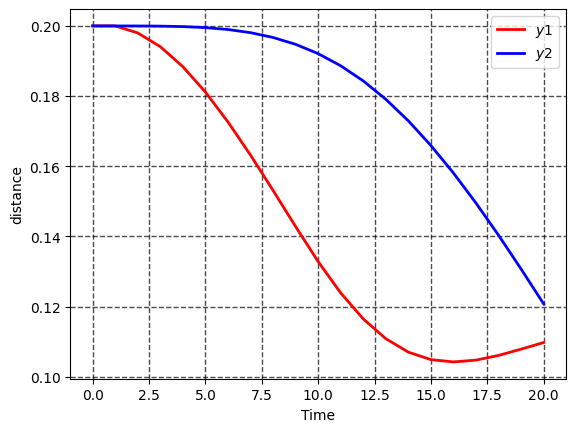

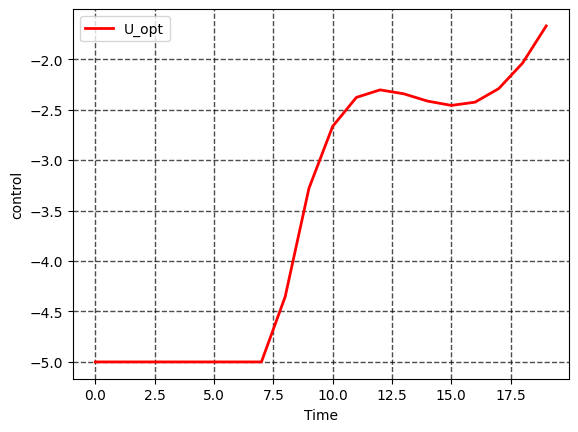

In [32]:
print(X_opt.shape)
print(U_opt.shape)
y1, y2 = X_opt

plot(y1[:-1], 'r', linewidth=2.0, label = r'$y1$')
plot(y2[:-1], 'b', linewidth=2.0, label = r'$y2$')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
legend()
ylabel('distance')
xlabel('Time')
show()

plot(U_opt[0,:-1], 'r', linewidth=2.0, label = "U_opt")
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
legend()
ylabel('control')
xlabel('Time')
show()

### Simulation

In [33]:
# dx = []

# def V_fun(x, param):
#     m1, m2, k = param
#     y1, y2 = x
#     V1 = k*(y1 - y2)
#     V2 = k*(y2 - y1)
#     return np.array([V1, V2])

u_max = 10
solve_time = []
time_stat = []
U = 0

problem.param_dict['U_max'].value = [u_max]
problem.param_dict['U_min'].value = [-u_max]


pos_0 = np.array([0.2, 0.2])
POS = pos_0
v0 = np.zeros(2)
x0 = np.hstack((pos_0, v0))
pos_p = pos_0 - v0*dt  
 
X_runge = np.zeros((4, len(t)))
X_runge[:, 0] = x0

def f(x, u, parameters):
    m1, m2, k = parameters
    y1, y2, dy1, dy2 = x

    ddy1 = 1/m1 *(u - k*(y1 - y2))
    ddy2 = 1/m2 *(-k*(y2 - y1))

    return np.array([dy1, dy2, ddy1, ddy2])

for k in range(N):
  # MPC CONTROL
  problem.param_dict['x_init_0'].value = pos_p
  problem.param_dict['x_init_1'].value = pos_0
  
  t1 = time.perf_counter()
  val = problem.solve()
  t2 = time.perf_counter()
  time_stat.append(t2 - t1)

  U_opt = problem.var_dict['U'].value
  u = U_opt[0][0]
  
  k1 = f(X_runge[:, k], u, param)
  k2 = f(X_runge[:, k] + ((dt/2)*k1), u, param)
  k3 = f(X_runge[:, k] + ((dt/2)*k2), u, param)
  k4 = f(X_runge[:, k] + (dt*k3), u,  param)
  
  X_runge[:, k+1] = X_runge[:, k] + (dt/6)*(k1 + 2*k2 + 2*k3 + k4) 

  pos_p = pos_0
  pos_0 = X_runge[:2, k+1]
  U = np.vstack((U, u))
  
y1, y2, dy1, dy2 = X_runge
t = np.array(range(N+1))*dt

  # x0 = A_d@x0 + B_d@[u]

  # x0 = -pos_p + 2*pos_0 + dt**2 * np.linalg.inv(M_mat) @ (u - V_fun(pos_0, param)) 
  # dx_var = (pos_0 - pos_p)/(dt)

  # X = np.vstack((X, x0))
  # U = np.vstack((U, u))

  # dx.append(dx_var)
  # POS = np.vstack((POS, pos_0))

# dx = np.array(dx)
# y1, y2 = np.split(POS, 2, axis = 1)


In [34]:
np.mean(time_stat)

0.008190083999536

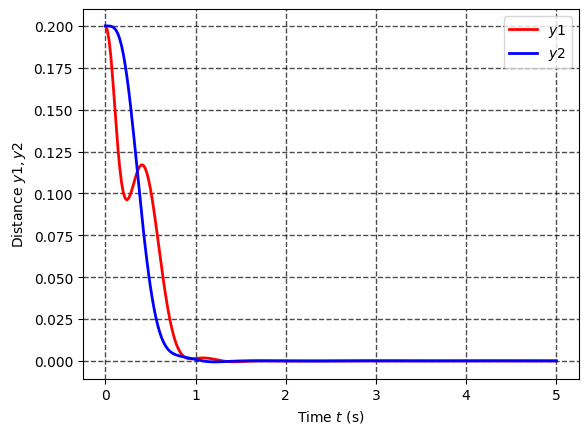

In [35]:
plot(t, y1, 'r', linewidth=2.0, label = r'$y1$')
plot(t, y2, 'b', linewidth=2.0, label = r'$y2$')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
legend()
ylabel(r'Distance $y1, y2$')
xlabel(r'Time $t$ (s)')
show()

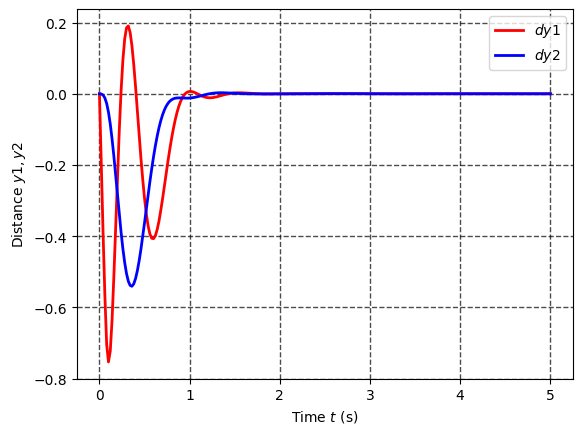

In [36]:
# dy1, dy2 = np.split(dx, 2, axis = 1)

plot(t, dy1, 'r', linewidth=2.0, label = r'$dy1$')
plot(t, dy2, 'b', linewidth=2.0, label = r'$dy2$')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
legend()
ylabel(r'Distance $y1, y2$')
xlabel(r'Time $t$ (s)')
show()

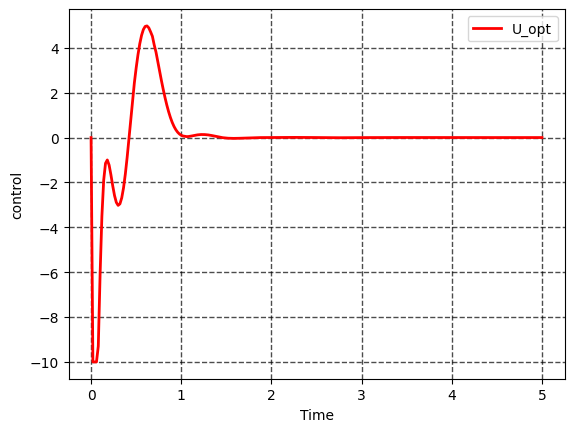

In [37]:
plot(t, U, 'r', linewidth=2.0, label = "U_opt")
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
legend()
ylabel('control')
xlabel('Time')
show()